# Finding Line Strengths from Galaxy Spectra

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from specutils.fitting import fit_generic_continuum
from specutils.spectra import Spectrum1D

In [4]:
def w2f(w):
    return (299792458/w)*0.01 # AA to THz

def f2w(f):
    return (299792458/f)*0.01 # THz to AA

### Visualising Data for galaxy NGC1275

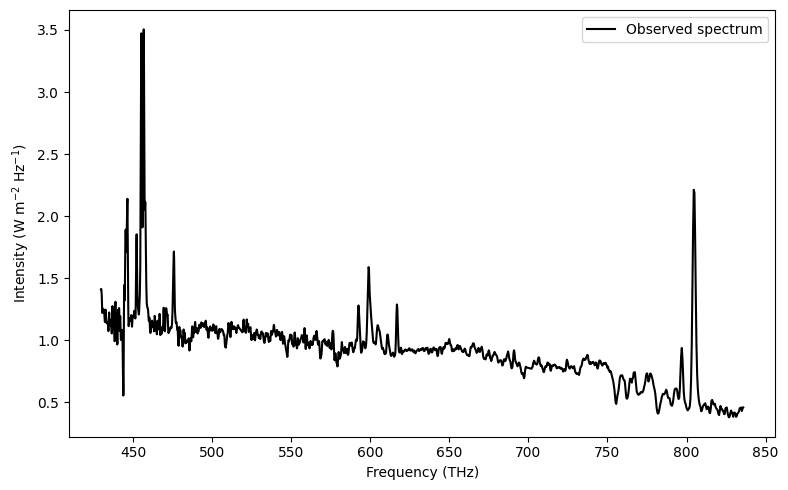

In [6]:
z = 0.017670 # redshift
lambda_, intensity = np.loadtxt('data/ngc1275.csv', delimiter=',', unpack = True, usecols = (0,1)) # Angstrom, W / (m^2 Hz)
lambda_ /= 1+z
frequency = w2f(lambda_)

plt.figure(figsize=(8,5))
plt.plot(frequency, intensity, 'k', label='Observed spectrum')  

plt.xlabel('Frequency (THz)')
plt.ylabel('Intensity (W m$^{-2}$ Hz$^{-1}$)')
plt.legend()
plt.tight_layout()

### Continuum Fitting

In [9]:
# Least square straight line fit
def linregress(x, y):
    n = len(x)
    Sxx = x@x
    Sxy = x@y
    Sy = np.sum(y)
    Sx = np.sum(x)
    delta = n*Sxx - (Sx)**2
    slope = (n*Sxy - Sx*Sy) / delta
    intercept = (Sxx*Sy - Sx*Sxy) / delta
    return slope, intercept

<QuantityModel Chebyshev1D(3, c0=-6.37124029, c1=0.00379377, c2=-0.00000033, c3=0.), input_units=Angstrom, return_units=Jy> [3586.62434777 3588.58962139 3590.55489501 ... 6972.7907868  6974.75606041
 6976.72133403] [0.4498 0.4498 0.4498 ... 1.4085 1.4101 1.4101]
<QuantityModel Chebyshev1D(3, c0=-6.37124029, c1=0.00379377, c2=-0.00000033, c3=0.), input_units=Angstrom, return_units=Jy>


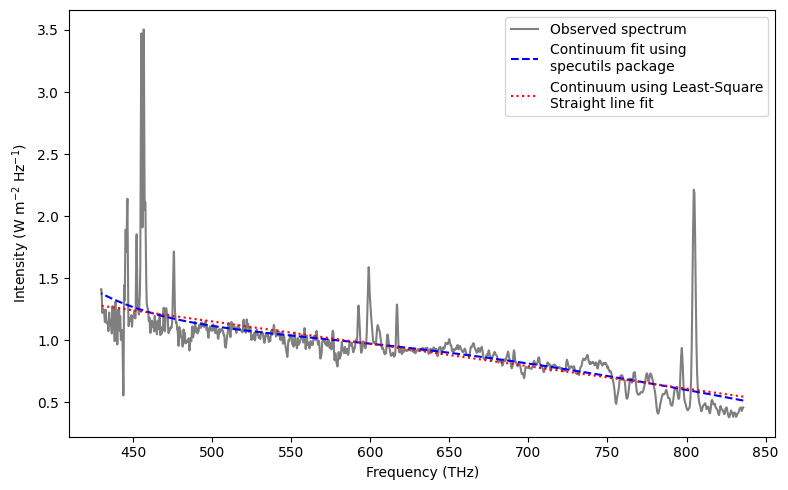

In [10]:
plt.figure(figsize=(8,5))
plt.plot(frequency, intensity, 'k', label='Observed spectrum', alpha=0.5)  

# using specutils package
spectrum = Spectrum1D(flux=intensity*u.Jy, spectral_axis=lambda_*u.angstrom)
g1_fit = fit_generic_continuum(spectrum)
y_continuum_2 = g1_fit(lambda_*u.angstrom)
flux = intensity/y_continuum_2
plt.plot(frequency, y_continuum_2, 'b--', label='Continuum fit using\nspecutils package')

# using least square fitting
slope, intercept = linregress(frequency, intensity)
y_continuum_1 = slope*frequency+intercept
plt.plot(frequency, y_continuum_1, 'r:', label='Continuum using Least-Square\nStraight line fit')

plt.xlabel('Frequency (THz)')
plt.ylabel('Intensity (W m$^{-2}$ Hz$^{-1}$)')
plt.legend()
plt.tight_layout()
plt.savefig('plots/3/continuum.png', dpi=200)

After Continuum Subtraction

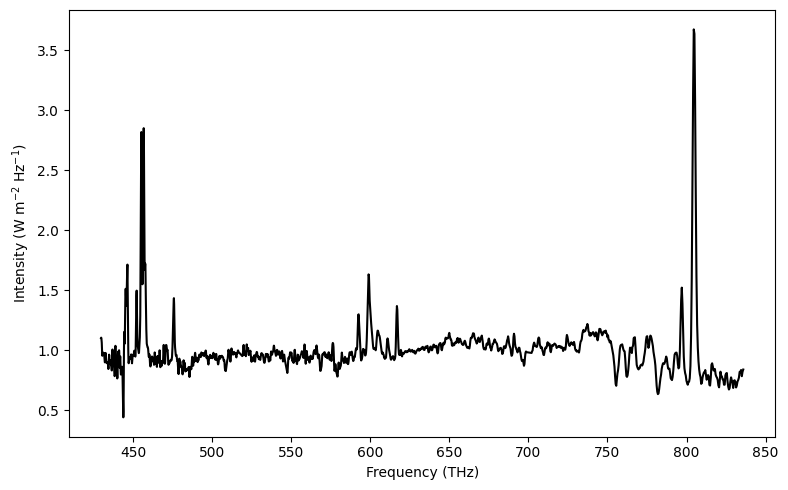

In [11]:
plt.figure(figsize=(8,5))

flux = intensity/y_continuum_1
plt.plot(frequency, flux, 'k')

plt.xlabel('Frequency (THz)')
plt.ylabel('Intensity (W m$^{-2}$ Hz$^{-1}$)')
plt.tight_layout()
plt.savefig('plots/3/continuum_sub.png', dpi=200)

### Applying Median Filter

For kernel = 1,
$$
f[i] = \text{median}(f[i-1],f[i],f[i+1])
$$

In [12]:
def medfiltt(x, k=3):
    n = len(x)
    xs = np.zeros(n)
    for i in range(n):
        a = i-k if i >= k else 0
        b = i+k if i <= n-k else -1 
        xs[i] = np.median(x[a:b])
    return xs

flux_smooth = medfiltt(flux)

### Finding peaks

Function to find derivatives

In [13]:
def dydx(y, order=1):
    dy = np.zeros(len(y))
    if order == 1:
        for i in range(1, len(y)-1):
            dy[i] = (y[i+1]-y[i-1])/2
            
    elif order == 2:
        for i in range(2, len(y)-2):
            dy[i] = (-y[i+2] + 8*y[i+1] - 8*y[i-1] + y[i-2])/12
            
    elif order == 3:
        for i in range(3, len(y)-3):
            dy[i] = (y[i+3] - 9*y[i+2] + 15*y[i+1] - 15*y[i-1] + 9*y[i-2] - y[i-3])/60
    
    elif order == 4:
        for i in range(4, len(y)-4):
            dy[i] = (-y[i+4] + (4*280/105)*y[i+3] - 56*y[i+2] + 224*y[i+1] - 224*y[i-1] + 56*y[i-2] - (4*280/105)*y[i-3] + y[i+4])/280
            
    return dy[:]

[806.2626605  599.39055154 475.95911191 458.09277888]


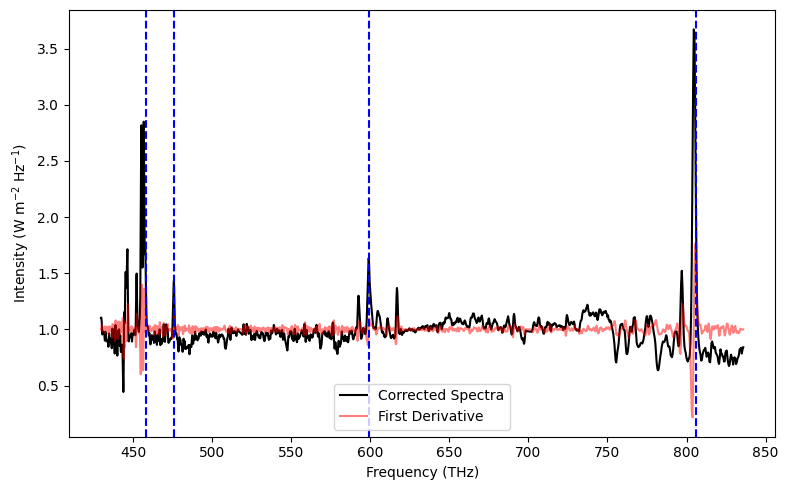

In [14]:
plt.figure(figsize=(8,5))
plt.plot(frequency, flux, 'k', label='Corrected Spectra')

threshold = 0.080
flux_smooth = medfiltt(flux, 1)
dy4 = dydx(flux_smooth, 4)
line_fs = frequency[np.where((dy4>threshold) & (flux_smooth>1.3))]
realines = []
i = 0
while i < len(line_fs):
    realines.append(line_fs[i])
    for j in range(i+1, len(line_fs)):
        if abs(line_fs[i] - line_fs[j]) <= 10:
            i += 1
    i += 1
    
realines = np.array(realines)
print(realines)
plt.plot(frequency, dy4+1, 'r', alpha=0.5, label='First Derivative')
# plt.plot(frequency, flux_smooth, 'r', alpha=0.8)
for line in realines:
    plt.axvline(line, color='b', linestyle='--')

plt.xlabel('Frequency (THz)')
plt.ylabel('Intensity (W m$^{-2}$ Hz$^{-1}$)')
plt.tight_layout()
plt.legend()
plt.savefig('plots/3/peaks.png', dpi=200)

### Gaussian fitting the emission lines

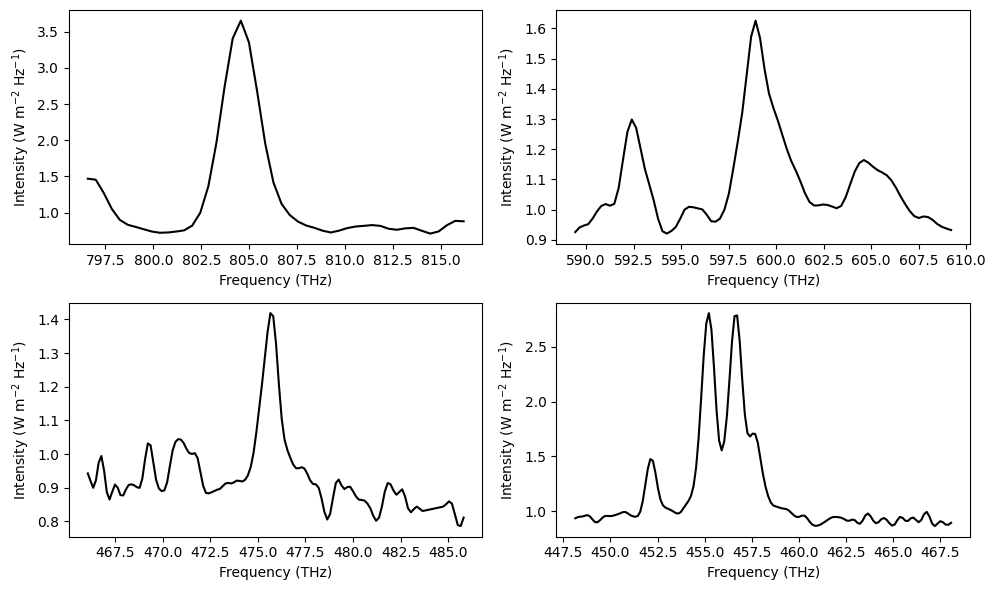

In [15]:
plt.figure(figsize=(10,6))
i = 0
for line in realines:
    window = np.where((frequency > line-10) & (frequency < line+10))
    plt.subplot(221+i)
    plt.plot(frequency[window], flux_smooth[window], 'k', alpha=1)
    plt.ylabel('Intensity (W m$^{-2}$ Hz$^{-1}$)')
    plt.xlabel('Frequency (THz)')
    i += 1
plt.tight_layout()
plt.savefig('plots/3/peaks_zoom.png', dpi=200)

In [16]:
from scipy.optimize import curve_fit 

def gaussian(x, amplitude=1, mean=0, stddev=1): 
    y = amplitude*np.exp(-((x-mean)**2)/(2*stddev**2)) 
    return y 

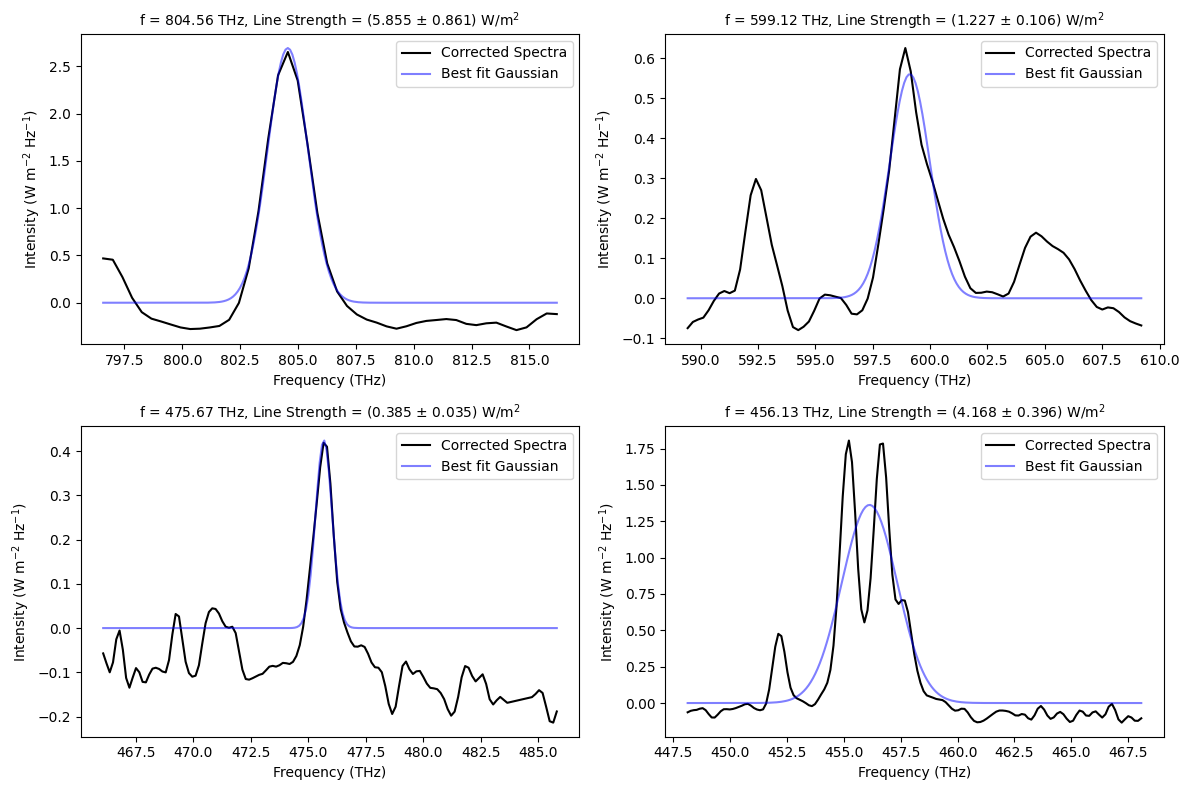

In [22]:
final_lines = {}

plt.figure(figsize=(12,8))
i = 0

for line in realines:
    window = np.where((frequency > line-10) & (frequency < line+10))
    xs = frequency[window]
    ys = flux_smooth[window] - 1
    
    plt.subplot(221+i)
    plt.plot(xs, ys, 'k', alpha=1, label='Corrected Spectra')
    
    params, cov = curve_fit(gaussian, xs, ys, p0=[np.max(ys), line, 5])
    fit_x = np.linspace(xs[-1], xs[0], 200)
    fit_y = gaussian(fit_x, params[0], params[1], params[2]) 
    strength = abs(params[0]*params[2]*np.sqrt(2*np.pi))
    strength_err = strength*np.sqrt(cov[0][0] + cov[2][2])
    plt.plot(fit_x, fit_y, 'b-', label=f'Best fit Gaussian', alpha=0.5)
    plt.title(f'f = {params[1]:.2f} THz, Line Strength = ({strength:.3f} '+ r"$\pm$"+ f' {strength_err:.3f}) W/m'+r"$^{2}$", fontsize=10)
    # print(f'Line strength for f = {params[1]:.3f} THz: {strength:.3f}')
    final_lines[params[1]] = (strength, strength_err)
    
    plt.ylabel('Intensity (W m$^{-2}$ Hz$^{-1}$)')
    plt.xlabel('Frequency (THz)')
    plt.legend(loc='upper right')
    
    i += 1
    
plt.tight_layout()
plt.savefig('plots/3/peaks_zoom_fit.png', dpi=200)

In [23]:
# remove the double peak from final_lines list
final_lines.pop(list(final_lines.keys())[-1])

(4.1677142880984865, 0.3962099560717569)

Handling double peaks

Area under fit1: 2.761628537911427
Area under fit2: 2.8443785123386705


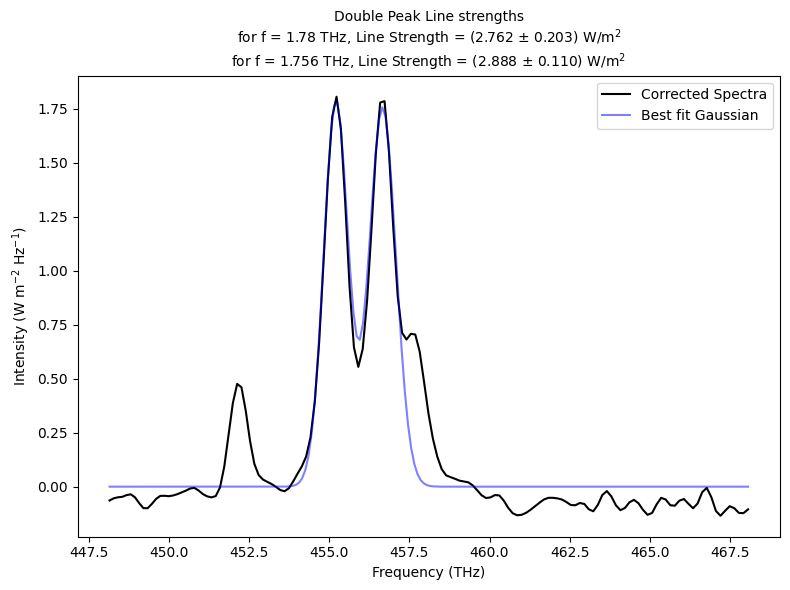

In [24]:
plt.figure(figsize=(8,6))
line = realines[3]
line1 = 455
line2 = 457

window = np.where((frequency > line-10) & (frequency < line+10))
xs = frequency[window]
ys = flux_smooth[window] - 1
plt.plot(xs, ys, 'k', alpha=1, label='Corrected Spectra')

# define the first window by cutting of the second peak
win1 = np.where(xs < line1+0.8)
params1, cov1 = curve_fit(gaussian, xs[win1], ys[win1], p0=[1.75, line1, 0.1])
win2 = np.where((xs > line2-1) & (xs < line2+0.4))
params2, cov2 = curve_fit(gaussian, xs[win2], ys[win2], p0=[2, line2, 0.5])

# define the second window by cutting of the first peak
fit_x = np.linspace(xs[-1], xs[0], 200)
fit_y1 = gaussian(fit_x, params1[0], params1[1], params1[2]) 
fit_y2 = gaussian(fit_x, params2[0], params2[1], params2[2]) 

# final curve fit is the addition of the two emission lines
plt.plot(fit_x, fit_y1+fit_y2, 'b-', label='Best fit Gaussian', alpha=0.5) 
print('Area under fit1:', params1[0]*np.sqrt(params1[2]*2*np.pi))
print('Area under fit2:', params2[0]*np.sqrt(params2[2]*2*np.pi))
strength1 = params1[0]*np.sqrt(params1[2]*2*np.pi)
strength2 = params1[0]*np.sqrt(params2[2]*2*np.pi)
strength1_err = strength1*np.sqrt(cov1[0][0] + cov1[2][2]/4)
strength2_err = strength2*np.sqrt(cov2[0][0] + cov2[2][2]/4)

plt.ylabel('Intensity (W m$^{-2}$ Hz$^{-1}$)')
plt.xlabel('Frequency (THz)')
plt.legend()
plt.title(f'Double Peak Line strengths\nfor f = {params1[0]:.2f} THz, Line Strength = ({strength1:.3f} '+ r"$\pm$"+ f' {strength1_err:.3f}) W/m'+r"$^{2}$"+
          f'\nfor f = {params2[0]:.3f} THz, Line Strength = ({strength2:.3f} '+ r"$\pm$"+ f' {strength2_err:.3f}) W/m'+r"$^{2}$", fontsize=10)
plt.tight_layout()
plt.savefig('plots/3/double_peak.png', dpi=200)

final_lines[params1[1]] = (strength1, strength1_err)
final_lines[params2[1]] = (strength2, strength2_err)

### Matching with Literature Data

http://astronomy.nmsu.edu/drewski/tableofemissionlines.html

Emission Lines Found:

f = 804.56 THz (3726.2 AA), possibly due to O II (3726.032 AA)
  Line Strength = (5.855 ± 0.861) W/m^2
f = 599.12 THz (5003.9 AA), possibly due to O III (5006.843 AA)
  Line Strength = (1.227 ± 0.106) W/m^2
f = 475.67 THz (6302.5 AA), possibly due to O I (6300.304 AA)
  Line Strength = (0.385 ± 0.035) W/m^2
f = 455.20 THz (6585.9 AA), possibly due to N II (6583.46 AA)
  Line Strength = (2.762 ± 0.203) W/m^2
f = 456.66 THz (6564.9 AA), possibly due to Hα (6562.819 AA)
  Line Strength = (2.888 ± 0.110) W/m^2


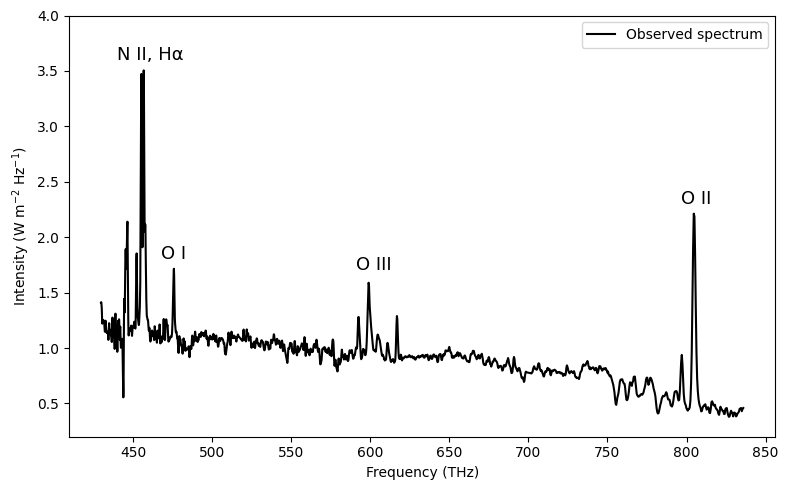

In [ ]:
import pandas as pd
plt.figure(figsize=(8,5))
plt.plot(frequency, intensity, 'k', label='Observed spectrum')  

data = pd.read_csv('data/spectral_lines.csv')
print('Emission Lines Found:\n')

i = 0
ys = [2.3, 1.7, 1.8]
# xs = 
for line, strength in final_lines.items():
    line_w = f2w(line)
    ion = data.iloc[(data['lambda']-line_w).abs().argsort()[0]]
    print(f'f = {line:.2f} THz ({line_w:.1f} AA), possibly due to {ion["Ion"]} ({ion["lambda"]} AA)\n  Line Strength = ({strength[0]:.3f} ± {strength[1]:.3f}) W/m^2')

    if line > 470:
        plt.text(x=line-8, y=ys[i], s=ion["Ion"], fontsize=13)
    i+=1
    
plt.text(x=440, y=3.6, s='N II, Hα', fontsize=13)

plt.xlabel('Frequency (THz)')
plt.ylabel('Intensity (W m$^{-2}$ Hz$^{-1}$)')  
plt.legend()
plt.ylim(0.2, 4)
plt.tight_layout()
plt.savefig('plots/3/final.png', dpi=200) 